In [1]:
import os
import pandas as pd
import time
import csv
import numpy as np
import sklearn.preprocessing as preprocessing
import pickle
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
import datetime



In [2]:
'''
functions.py for features extraction
extract 35 features
'''
import numpy as np
import math
from scipy.fftpack import fft
from scipy.fftpack.realtransforms import dct
import pywt
from scipy import signal as sig


def wden(x, tptr, sorh, scal, n, wname):
    # epsilon stands for a very small number
    eps = 2.220446049250313e-16

    # decompose the input signal. Symetric padding is given as a default.
    coeffs = pywt.wavedec(x, wname, 'sym', n)

    # threshold rescaling coefficients
    if scal == 'one':
        s = [1]
    elif scal == 'sln':
        s = wnoisest(coeffs)
    elif scal == 'mln':
        s = wnoisest(coeffs, level=n)
    else:
        raise ValueError('Invalid value for scale, scal = %s' % (scal))

    # wavelet coefficients thresholding
    coeffsd = [coeffs[0]]
    for i in range(0, n):
        if tptr == 'sqtwolog' or tptr == 'minimaxi':
            th = thselect(x, tptr)
        else:
            if len(s) == 1:
                if s[0] < math.sqrt(eps) * max(coeffs[1 + i]):
                    th = 0
                else:
                    th = thselect(coeffs[1 + i] / s[0], tptr)
            else:
                if s[i] < math.sqrt(eps) * max(coeffs[1 + i]):
                    th = 0
                else:
                    th = thselect(coeffs[1 + i] / s[i], tptr)

        ### DEBUG
        #        print "threshold before rescaling:", th
        ###

        # rescaling
        if len(s) == 1:
            th = th * s[0]
        else:
            th = th * s[i]

        #### DEBUG
        #        print "threshold:", th
        ####

        coeffsd.append(np.array(wthresh(coeffs[1 + i], sorh, th)))

    # wavelet reconstruction
    xdtemp = pywt.waverec(coeffsd, wname, 'sym')

    # get rid of the extended part for wavelet decomposition
    extlen = abs(len(x) - len(xdtemp)) // 2
    xd = xdtemp[extlen:len(x) + extlen]

    return xd


def thselect(x, tptr):
    x = np.array(x)  # in case that x is not an array, convert it into an array
    l = len(x)

    if tptr == 'rigrsure':
        sx2 = [sx * sx for sx in np.absolute(x)]
        sx2.sort()
        cumsumsx2 = np.cumsum(sx2)
        risks = []
        for i in range(0, l):
            risks.append(
                (l - 2 * (i + 1) + (cumsumsx2[i] + (l - 1 - i) * sx2[i])) / l)
        mini = np.argmin(risks)
        th = math.sqrt(sx2[mini])
    if tptr == 'heursure':
        hth = math.sqrt(2 * math.log(l))

        # get the norm of x
        normsqr = np.dot(x, x)
        eta = 1.0 * (normsqr - l) / l
        crit = (math.log(l, 2) ** 1.5) / math.sqrt(l)

        ### DEBUG
        #        print "crit:", crit
        #        print "eta:", eta
        #        print "hth:", hth
        ###

        if eta < crit:
            th = hth
        else:
            sx2 = [sx * sx for sx in np.absolute(x)]
            sx2.sort()
            cumsumsx2 = np.cumsum(sx2)
            risks = []
            for i in range(0, l):
                risks.append((l - 2 * (i + 1) + (
                            cumsumsx2[i] + (l - 1 - i) * sx2[i])) / l)
            mini = np.argmin(risks)

            ### DEBUG
            #            print "risk:", risks[mini]
            #            print "best:", mini
            #            print "risks[222]:", risks[222]
            ###

            rth = math.sqrt(sx2[mini])
            th = min(hth, rth)
    elif tptr == 'sqtwolog':
        th = math.sqrt(2 * math.log(l))
    elif tptr == 'minimaxi':
        if l < 32:
            th = 0
        else:
            th = 0.3936 + 0.1829 * math.log(l, 2)
    else:
        raise ValueError(
            'Invalid value for threshold selection rule, tptr = %s' % (tptr))

    return th


#################################
#
# wthresh(x, sorh, t) returns the soft (sorh = 'soft') or hard (sorh = 'hard')
# thresholding of x, the given input vector. t is the threshold.
# sorh = 'hard', hard trehsholding
# sorh = 'soft', soft thresholding
#

def wthresh(x, sorh, t):
    if sorh == 'hard':
        y = [e * (abs(e) >= t) for e in x]
    elif sorh == 'soft':
        y = [((e < 0) * -1.0 + (e > 0)) * ((abs(e) - t) * (abs(e) >= t)) for e
             in x]
    else:
        raise ValueError(
            'Invalid value for thresholding type, sorh = %s' % (sorh))

    return y


#################################
#
# wnoisest(coeffs, level = None) estimates the variance(s) of the given detail(s)
#
# coeffs = [CAn, CDn, CDn-1, ..., CD1], multi-level wavelet coefficients
# level, decomposition level. None is the default.
#

def wnoisest(coeffs, level=None):
    l = len(coeffs) - 1

    if level == None:
        sig = [abs(s) for s in coeffs[-1]]
        stdc = median(sig) / 0.6745
    else:
        stdc = []
        for i in range(0, l):
            sig = [abs(s) for s in coeffs[1 + i]]
            stdc.append(median(sig) / 0.6745)

    return stdc


#################################
#
# median(data) returns the median of data
#
# data, a list of numbers.
#

def median(data):
    temp = data[:]
    temp.sort()
    dataLen = len(data)
    if dataLen % 2 == 0:  # even number of data points
        med = (temp[dataLen / 2 - 1] + temp[dataLen / 2]) / 2.0
    else:
        med = temp[dataLen / 2]

    return med


def stFeatureExtraction(signal, fs, win, step):
    """
    This function implements the shor-term windowing process.
    For each short-term window a set of features is extracted.
    This results to a sequence of feature vectors, stored in a np matrix.
    ARGUMENTS
        signal:       the input signal samples
        fs:           the sampling freq (in Hz)
        win:          the short-term window size (in samples)
        step:         the short-term window step (in samples)
    RETURNS
        st_features:   a np array (n_feats x numOfShortTermWindows)
    """

    # win = round(win*fs)
    # step = round(step*fs)

    # signal normalization
    # signal = np.double(signal)
    # signal = signal / (2.0 ** 15)
    # DC = signal.mean()
    # MAX = (np.abs(signal)).max()
    # signal = (signal - DC) / (MAX + 0.0000000001)

    N = len(signal)  # total number of samples
    cur_p = 0
    count_fr = 0
    hamming_window = sig.windows.hamming(win)
    nFFT = int(win / 2)

    mfccParams = feature_mfccs_init(win, fs)

    # 8 0 13 13
    n_time_spectral_feats = 8
    n_harmonic_feats = 2
    n_mfcc_feats = 13
    n_chroma_feats = 12
    n_total_feats = n_time_spectral_feats + n_mfcc_feats + \
                    n_harmonic_feats + n_chroma_feats
#    n_total_feats = n_time_spectral_feats + n_mfcc_feats + n_harmonic_feats
    feature_names = []
    feature_names.append("zcr")
    feature_names.append("energy")
    feature_names.append("energy_entropy")
    feature_names += ["spectral_centroid", "spectral_spread"]
    feature_names.append("spectral_entropy")
    feature_names.append("spectral_flux")
    feature_names.append("spectral_rolloff")
    feature_names += ["mfcc_{0:d}".format(mfcc_i)
                      for mfcc_i in range(1, n_mfcc_feats+1)]
    feature_names += ["harmonic_{0:d}".format(harmonic_i)
                      for harmonic_i in range(1, n_harmonic_feats+1)]
    feature_names += ["chroma_{0:d}".format(chroma_i)
                      for chroma_i in range(1, n_chroma_feats)]
    # feature_names.append("chroma_std")
    st_features = []
    while cur_p + win - 1 < N:  # for each short-term window to end of signal
        count_fr += 1
        x = signal[cur_p:cur_p+win]  # get current window
        x = x * hamming_window
        cur_p = cur_p + step   # update window position
        X = abs(fft(x)) # get fft magnitude
        X = X[0:nFFT]  # normalize fft
        X = X / len(X)
        if count_fr == 1:
            X_prev = X.copy()  # keep previous fft mag (used in spectral flux)
        curFV = np.zeros((n_total_feats, 1))
        curFV[0] = stZCR(x)  # zero crossing rate
        curFV[1] = stEnergy(x)  # short-term energy
        curFV[2] = stEnergyEntropy(x)  # short-term entropy of energy
        [curFV[3], curFV[4]] = stSpectralCentroidAndSpread(X, fs)  # sp centroid/spread
        curFV[5] = stSpectralEntropy(X, 10)   # spectral entropy
        curFV[6] = stSpectralFlux(X, X_prev)   # spectral flux
        curFV[7] = stSpectralRollOff(X, 0.90, fs)   # spectral rolloff
        curFV[n_time_spectral_feats:n_time_spectral_feats+n_mfcc_feats, 0] = \
            feature_mfccs(X, mfccParams)    # MFCCs

        [HR, F0] = feature_harmonic(x, fs)
        curFV[n_time_spectral_feats+n_mfcc_feats:n_time_spectral_feats+n_mfcc_feats+n_harmonic_feats, 0] = \
            np.array([[HR], [F0]]).reshape((2, ))

        curFV[n_time_spectral_feats+n_mfcc_feats+n_harmonic_feats:
              n_time_spectral_feats+n_mfcc_feats+n_harmonic_feats+n_chroma_feats] = \
            feature_chroma_vector(x, fs)[0]

        # curFV[n_time_spectral_feats+n_mfcc_feats+n_harmonic_feats+n_chroma_feats-1] = \
        #     chromaF.std()
        st_features.append(curFV)
        # delta features
        '''
        if count_fr>1:
            delta = curFV - prevFV
            curFVFinal = np.concatenate((curFV, delta))            
        else:
            curFVFinal = np.concatenate((curFV, curFV))
        prevFV = curFV
        st_features.append(curFVFinal)        
        '''
        # end of delta
        X_prev = X.copy()

    st_features = np.concatenate(st_features, 1)
    return st_features, feature_names

def mfccInitFilterBanks(fs, nfft, lowfreq=133.33, linc=200/3, logsc=1.0711703,
                        numLinFiltTotal=13, numLogFilt=27):
    """
    Computes the triangular filterbank for MFCC computation
    (used in the stFeatureExtraction function before the stMFCC function call)
    This function is taken from the scikits.talkbox library (MIT Licence):
    https://pypi.python.org/pypi/scikits.talkbox
    """

    if fs < 8000:
        nlogfil = 5

    # Total number of filters
    nFiltTotal = numLinFiltTotal + numLogFilt

    # Compute frequency points of the triangle:
    freqs = np.zeros(nFiltTotal+2)
    freqs[:numLinFiltTotal] = lowfreq + np.arange(numLinFiltTotal) * linc
    freqs[numLinFiltTotal:] = freqs[numLinFiltTotal-1] * logsc ** \
                              np.arange(1, numLogFilt + 3)
    heights = 2./(freqs[2:] - freqs[0:-2])

    # Compute filterbank coeff (in fft domain, in bins)
    fbank = np.zeros((nFiltTotal, nfft))
    nfreqs = np.arange(nfft) / (1. * nfft) * fs

    for i in range(nFiltTotal):
        lowTrFreq = freqs[i]
        cenTrFreq = freqs[i+1]
        highTrFreq = freqs[i+2]

        lid = np.arange(np.floor(lowTrFreq * nfft / fs) + 1,
                           np.floor(cenTrFreq * nfft / fs) + 1,
                           dtype=np.int)
        lslope = heights[i] / (cenTrFreq - lowTrFreq)
        rid = np.arange(np.floor(cenTrFreq * nfft / fs) + 1,
                                       np.floor(highTrFreq * nfft / fs) + 1,
                           dtype=np.int)
        rslope = heights[i] / (highTrFreq - cenTrFreq)
        fbank[i][lid] = lslope * (nfreqs[lid] - lowTrFreq)
        fbank[i][rid] = rslope * (highTrFreq - nfreqs[rid])

    return fbank, freqs


def stChromaFeaturesInit(nfft, fs):
    """
    This function initializes the chroma matrices used in the calculation
    of the chroma features
    """
    freqs = np.array([((f + 1) * fs) / (2 * nfft) for f in range(nfft)])
    Cp = 27.50
    nChroma = np.round(12.0 * np.log2(freqs / Cp)).astype(int)

    nFreqsPerChroma = np.zeros((nChroma.shape[0],))

    uChroma = np.unique(nChroma)
    for u in uChroma:
        idx = np.nonzero(nChroma == u)
        nFreqsPerChroma[idx] = idx[0].shape

    return nChroma, nFreqsPerChroma


def stChromaFeatures(X, fs, nChroma, nFreqsPerChroma, num_feats):
    # TODO: 1 complexity
    # TODO: 2 bug with large windows

    chromaNames = ['A', 'A#', 'B', 'C', 'C#', 'D',
                   'D#', 'E', 'F', 'F#', 'G', 'G#']
    spec = X ** 2
    if nChroma.max() < nChroma.shape[0]:
        C = np.zeros((nChroma.shape[0],))
        C[nChroma] = spec
        C /= nFreqsPerChroma[nChroma]
    else:
        I = np.nonzero(nChroma > nChroma.shape[0])[0][0]
        C = np.zeros((nChroma.shape[0],))
        C[nChroma[0:I - 1]] = spec
        C /= nFreqsPerChroma
    finalC = np.zeros((int(num_feats), 1))
    newD = int(np.ceil(C.shape[0] / num_feats) * num_feats)
    C2 = np.zeros((newD,))
    C2[0:C.shape[0]] = C
    C2 = C2.reshape(int(C2.shape[0] / num_feats), num_feats)
    # for i in range(12):
    #    finalC[i] = np.sum(C[i:C.shape[0]:12])
    finalC = np.array(np.sum(C2, axis=0)).T
    finalC /= spec.sum()

    #    ax = plt.gca()
    #    plt.hold(False)
    #    plt.plot(finalC)
    #    ax.set_xticks(range(len(chromaNames)))
    #    ax.set_xticklabels(chromaNames)
    #    xaxis = np.arange(0, 0.02, 0.01);
    #    ax.set_yticks(range(len(xaxis)))
    #    ax.set_yticklabels(xaxis)
    #    plt.show(block=False)
    #    plt.draw()

    return chromaNames, finalC


def stZCR(frame):
    """Computes zero crossing rate of frame"""
    # count = len(frame)
    # countZ = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    # return (np.float64(countZ) / np.float64(count-1.0))
    frame2 = np.zeros(len(frame))
    frame2[1:] = frame[0: -1]
    Z = (1 / (2 * len(frame))) * sum(abs(np.sign(frame) - np.sign(frame2)))
    return Z


def stEnergy(frame):
    """Computes signal energy of frame"""
    return np.sum(np.power(abs(frame), 2)) / len(frame)


def stEnergyEntropy(frame, n_short_blocks=10):
    eps = 2.220446049250313e-16
    """Computes entropy of energy"""
    Eol = np.sum(frame ** 2)    # total frame energy
    L = len(frame)
    sub_win_len = int(np.floor(L / n_short_blocks))
    if L != sub_win_len * n_short_blocks:
            frame = frame[0:sub_win_len * n_short_blocks]
    # sub_wins is of size [n_short_blocks x L]
    sub_wins = frame.reshape(sub_win_len, n_short_blocks, order='F').copy()

    # Compute normalized sub-frame energies:
    s = np.sum(sub_wins ** 2, axis=0) / (Eol + eps)

    # Compute entropy of the normalized sub-frame energies:
    Entropy = -np.sum(s * np.log2(s + eps))
    return Entropy


def stSpectralCentroidAndSpread(X, fs):
    eps = 2.220446049250313e-16
    """Computes spectral centroid of frame (given abs(FFT))"""
    ind = (np.arange(1, len(X) + 1)) * (fs/(2.0 * len(X)))

    Xt = X.copy()
    Xt = Xt / Xt.max()
    NUM = np.sum(ind * Xt)
    DEN = np.sum(Xt) + eps

    # Centroid:
    C = (NUM / DEN)

    # Spread:
    S = np.sqrt(np.sum(((ind - C) ** 2) * Xt) / DEN)

    # Normalize:
    C = C / (fs / 2.0)
    S = S / (fs / 2.0)

    return (C, S)


def stSpectralEntropy(X, n_short_blocks=10):
    """Computes the spectral entropy"""
    eps = 2.220446049250313e-16
    L = len(X)   # number of frame samples
    Eol = np.sum(np.power(X, 2))   # total spectral energy

    sub_win_len = int(np.floor(L / n_short_blocks))  # length of sub-frame
    if L != sub_win_len * n_short_blocks:
        X = X[0:sub_win_len * n_short_blocks]

    # define sub-frames (using matrix reshape)
    sub_wins = X.reshape(sub_win_len, n_short_blocks, order='F').copy()
    # compute spectral sub-energies
    s = np.sum(np.power(sub_wins, 2), axis=0) / (Eol + eps)
    # compute spectral entropy
    En = -np.sum(s * np.log2(s + eps))

    return En


def stSpectralFlux(X, X_prev):
    """
    Computes the spectral flux feature of the current frame
    ARGUMENTS:
        X:            the abs(fft) of the current frame
        X_prev:        the abs(fft) of the previous frame
    """
    eps = 2.220446049250313e-16
    # compute the spectral flux as the sum of square distances:
    sumX = np.sum(X + eps)
    sumPrevX = np.sum(X_prev + eps)
    F = np.sum((X / sumX - X_prev/sumPrevX) ** 2)
    return F


def stSpectralRollOff(X, c, fs):
    """Computes spectral roll-off"""
    eps = 2.220446049250313e-16
    totalEnergy = np.sum(X ** 2)
    fftLength = len(X)
    Thres = c*totalEnergy
    # Ffind the spectral rolloff as the frequency position
    # where the respective spectral energy is equal to c*totalEnergy
    CumSum = np.cumsum(X ** 2) + eps
    [a, ] = np.nonzero(CumSum > Thres)
    if len(a) > 0:
        mC = np.float64(a[0]) / (float(fftLength))
    else:
        mC = 0.0
    return (mC)


def stMFCC(X, fbank, n_mfcc_feats):
    """
    Computes the MFCCs of a frame, given the fft mag
    ARGUMENTS:
        X:        fft magnitude abs(FFT)
        fbank:    filter bank (see mfccInitFilterBanks)
    RETURN
        ceps:     MFCCs (13 element vector)
    Note:    MFCC calculation is, in general, taken from the
             scikits.talkbox library (MIT Licence),
    #    with a small number of modifications to make it more
         compact and suitable for the pyAudioAnalysis Lib
    """
    eps = 2.220446049250313e-16
    mspec = np.log10(np.dot(X, fbank.T)+eps)
    ceps = dct(mspec, type=2, norm='ortho', axis=-1)[:n_mfcc_feats]
    return ceps


def stHarmonic(frame, fs):
    """
    Computes harmonic ratio and pitch
    """
    eps = 2.220446049250313e-16
    M = round(0.016 * fs) - 1
    R = np.correlate(frame, frame, mode='full')

    g = R[len(frame)-1]
    R = R[len(frame):-1]

    # estimate m0 (as the first zero crossing of R)
    [a, ] = np.nonzero(np.diff(np.sign(R)))

    if len(a) == 0:
        m0 = len(R)-1
    else:
        m0 = a[0]
    if M > len(R):
        M = len(R) - 1

    Gamma = np.zeros((M), dtype=np.float64)
    CSum = np.cumsum(frame ** 2)
    Gamma[m0:M] = R[m0:M] / (np.sqrt((g * CSum[M:m0:-1])) + eps)

    ZCR = stZCR(Gamma)

    if ZCR > 0.15:
        HR = 0.0
        f0 = 0.0
    else:
        if len(Gamma) == 0:
            HR = 1.0
            blag = 0.0
            Gamma = np.zeros((M), dtype=np.float64)
        else:
            HR = np.max(Gamma)
            blag = np.argmax(Gamma)

        # Get fundamental frequency:
        f0 = fs / (blag + eps)
        if f0 > 5000:
            f0 = 0.0
        if HR < 0.1:
            f0 = 0.0

    return (HR, f0)


# from matlab
def feature_mfccs_init(windowLength, fs):
    mfccParams = dict()
    mfccParams['cepstralCoefficients'] = 13
    mfccParams['fftSize'] = round(windowLength // 2)
    mfccParams['lowestFrequency'] = 133.3333
    mfccParams['linearFilters'] = 13
    mfccParams['linearSpacing'] = 66.66666666
    mfccParams['logFilters'] = 27
    mfccParams['logSpacing'] = 1.0711703
    mfccParams['totalFilters'] = \
        mfccParams['linearFilters'] + mfccParams['logFilters']
    mfccParams['freqs'] = np.array([mfccParams['lowestFrequency'] +
                                    i * mfccParams['linearSpacing']
                                    for i in range(mfccParams['linearFilters'])])
    mfccParams['freqs'] = np.append(mfccParams['freqs'],
                                    mfccParams['freqs'][mfccParams['linearFilters']-1] * \
                                    np.array([np.power(mfccParams['logSpacing'], i) for i in range(1, mfccParams['logFilters']+3)]))
    mfccParams['lower'] = mfccParams['freqs'][:mfccParams['totalFilters']]
    mfccParams['center'] = mfccParams['freqs'][1:mfccParams['totalFilters']+1]
    mfccParams['upper'] = mfccParams['freqs'][2:mfccParams['totalFilters']+2]
    mfccParams['mfccFilterWeights'] = np.zeros((mfccParams['totalFilters'],
                                               mfccParams['fftSize']))
    mfccParams['triangleHeight'] = 2/(mfccParams['upper']-mfccParams['lower'])
    mfccParams['fftFreqs'] = np.array([i for i in range(mfccParams['fftSize'])]) / mfccParams['fftSize'] * fs

    mfccParams['mfccFilterWeights'] = np.zeros((mfccParams['totalFilters'], mfccParams['fftSize']))
    for chan in range(mfccParams['totalFilters']):
        temp1 = np.array(mfccParams['fftFreqs'] > mfccParams['lower'][chan], dtype=np.int)
        temp2 = np.array(mfccParams['fftFreqs'] <= mfccParams['center'][chan], dtype=np.int)
        temp3 = (temp1 & temp2) * mfccParams['triangleHeight'][chan] * \
                (mfccParams['fftFreqs'] - mfccParams['lower'][chan]) / \
                (mfccParams['center'][chan] - mfccParams['lower'][chan]) + \
                (np.array(mfccParams['fftFreqs'] > mfccParams['center'][chan], dtype=np.int) &
                 np.array(mfccParams['fftFreqs'] < mfccParams['upper'][chan], dtype=np.int)) * \
                mfccParams['triangleHeight'][chan] * (mfccParams['upper'][chan]-mfccParams['fftFreqs']) / \
                (mfccParams['upper'][chan] - mfccParams['center'][chan])
        mfccParams['mfccFilterWeights'][chan, :] = temp3

    mfccParams['mfccDCTMatrix'] = 1 / np.sqrt(mfccParams['totalFilters']/2) * \
                                  np.cos(np.matmul(np.array([i for i in range(mfccParams['cepstralCoefficients'])]).reshape(1, -1).transpose(),
                                                   np.array([2*i+1 for i in range(mfccParams['totalFilters'])]).reshape(1, -1)) *
                                         np.pi/2/mfccParams['totalFilters'])
    mfccParams['mfccDCTMatrix'][0, :] = mfccParams['mfccDCTMatrix'][0,:] * np.sqrt(2) / 2
    return mfccParams


def feature_mfccs(windowFFT, mfccParams):
    eps = 2.220446049250313e-16
    earMag = np.log10(np.matmul(mfccParams['mfccFilterWeights'], windowFFT) + eps)
    ceps = np.matmul(mfccParams['mfccDCTMatrix'], earMag)
    return ceps


def feature_chroma_vector(x_in, Fs):
    eps = 2.220446049250313e-16
    x_in = x_in / max(np.abs(x_in))
    tone_analysis = 12
    num_of_bins = 12

    lengthx = len(x_in)
    winlength = lengthx
    freqs = np.arange(0., int(np.floor(winlength/2)-1)*(Fs/winlength)+Fs/winlength, Fs/winlength)
    f0 = 55
    f = np.array([])
    i = 0
    while True:
        f = np.append(f, f0 * np.power(2, (i / tone_analysis)))
        if f[-1] > freqs[-1]:
            f = np.delete(f, -1)
            break
        i = i + 1
    x = x_in
    fftMag = abs(fft(x)).transpose()
    fftMag = fftMag[:int(np.floor(winlength / 2))]
    the_max = max(fftMag)
    if the_max <= eps:
        ytemp = np.zeros((num_of_bins, 1))
        y = [ytemp]

    temp1 = np.array(freqs < f[0], dtype=int) | np.array(freqs > 2000, dtype=int)
    dfind = np.where(temp1)
    fftMag[dfind[0]] = np.zeros((1, len(dfind[0])))

    c1 = fftMag - np.append(np.array([0]), fftMag[0:len(fftMag)-1])
    c2 = fftMag - np.append(fftMag[1:len(fftMag)], np.array([0]))

    temp1 = np.array(c1 > 0) & np.array(c2 > 0)
    dfind = np.where((~temp1).astype(int))
    fftMag[dfind[0]] = np.zeros((1, len(dfind[0])))

    temp1 = np.array(fftMag > 0)
    nonzero = np.where(temp1.astype(int))
    nonzero = nonzero[0]
    if len(nonzero) == 0:
        y = np.zeros((num_of_bins, 1))

    ytemp = np.zeros((num_of_bins, 1))
    ctemp = np.zeros((num_of_bins, 1))
    for k in range(len(nonzero)):
        temp = freqs[nonzero[k]]
        val = abs(temp - f)
        MIN = np.min(val)
        pitch_class = list(val).index(MIN)
        h = np.remainder(pitch_class, num_of_bins)
        # if h == 0:
        #     h = num_of_bins
        ytemp[h] = ytemp[h] + fftMag[nonzero[k]]
        ctemp[h] = ctemp[h] + 1
    y = ytemp
    c = ctemp
    [K1, L1] = y.shape
    [K2, L2] = c.shape
    if L1 != L2:
        c = c.reshape(y.shape)
    C = y / (c + 1)
    return C, y, c


def feature_harmonic(window, Fs):
    eps = 2.220446049250313e-16
    M = round(0.016 * Fs)
    R = np.correlate(window, window, mode='full')
    g = R[len(window)-1]
    R = R[len(window):]
    i = 2

    m0 = len(R) + 1
    while i <= len(R):
        if np.array(R[i-1] < 0) & np.array(R[i-2] >= 0):
            m0 = i
            break
        i = i + 1
    if M > len(R):
        M = len(R)
    Gamma = np.zeros((M, 1))
    CSum = np.cumsum(np.power(window, 2))
    Gamma[m0-1: M, 0] = R[m0-1: M] / (np.sqrt((g * CSum[-1-m0+1:-1-M:-1])) + eps)
    Z = stZCR(Gamma.transpose().reshape(-1, ))
    if Z > 0.15:
        HR = 0
        f0 = 0
    else:
        if len(Gamma) == 0:
            HR = 1
            blag = 0
            Gamma = np.zeros((M, 1))
        else:
            HR = np.max(Gamma)
            blag = list(Gamma).index(HR)
        f0 = Fs / (blag+1)
        if f0 > 5000:
            f0 = 0
        if HR < 0.1:
            f0 = 0
    return HR, f0


def fft_result_logarithm(seg_data):
    y = np.squeeze(seg_data)
    n = len(y)  # length of the signal one second
    Y = np.fft.fft(y) / n  # fft computing and normalization
    Y1 = abs(Y[range(int(n / 2))])
    # logarithm output
    Y2 = 20 * np.log10(np.clip(np.abs(Y1), 1e-20, 1e100))
    return Y1, Y2

In [4]:
def load_rawdata_with_labels(f_dir):
    print("=====================")
    print("Loading OPV data ..........")
    all_rawdata = np.empty((0, 2))
    all_laebl = np.empty((0, 3))
    activity_dirs = os.listdir(f_dir)
    activity_dirs.sort()
    for folder in activity_dirs:
#         print(folder)
        # Check folder name
        label_buffer = folder.split('_')
#         print(len(label_buffer))
        if len(label_buffer) <= 10:
            continue
        # get class of this file
        try:
            folder_class_environment = int(label_buffer[1])
            folder_class_detection = int(label_buffer[3])
            folder_class_order = int(label_buffer[4])
        except:
            print("Wrong file name: {:s}".format(folder))
            continue
#         print(folder_class_1, folder_class_2)
        rawdata_csv_dir = f_dir+folder
#         print(rawdata_csv_dir)
        if os.path.exists(rawdata_csv_dir):
            load_data = np.genfromtxt(rawdata_csv_dir, delimiter=",")
#             print(load_data.shape)
            load_data = load_data[:, [2,1]]
            if len(load_data.shape) == 2:
                load_label_class_environment = np.full((load_data.shape[0], 1), folder_class_environment)
                load_label_class_detection = np.full((load_data.shape[0], 1), folder_class_detection)
                load_label_class_order = np.full((load_data.shape[0], 1), folder_class_order)
                load_label = np.hstack((load_label_class_environment.reshape(-1, 1), load_label_class_detection.reshape(-1, 1)))
                load_label = np.hstack((load_label, load_label_class_order.reshape(-1, 1)))
#                 print(load_data.shape)
#                 print(all_rawdata.shape)
                all_rawdata = np.vstack((all_rawdata, load_data))
                all_laebl = np.vstack((all_laebl, load_label))
    # range_fft = np.hstack((all_fft[:, 3:90], all_fft[:, 603:690]))
    return all_rawdata, all_laebl
        

In [5]:
# 信号平滑
WINDOWS = ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']

def smooth(x, window_len = 11, window = 'hanning'):
    if x.ndim != 1:
        raise ValueError('smooth only accepts 1 dimension arrays.')
    if x.size < window_len:
        raise ValueError('Input vector needs to be bigger than window size.')
    if window_len < 3:
        return x
    if not window in WINDOWS:
        raise ValueError('Window is one of "flat", "hanning", "hamming", "bartlett", "blackman"')
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    if window == 'flat':
        w = np.ones(window_len, 'd')
    else:
        w = eval('np.' + window + '(window_len)')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y

In [6]:
detect_dir = "./Data-Group4/Data-Group4-10LM/"
all_rawdata, all_laebl = load_rawdata_with_labels(detect_dir)

print("Rawdata shape: ", all_rawdata.shape)
print("Rawdata labels shape: ", all_laebl.shape)

lev = 5
window_len = 200

channels_n = all_rawdata.shape[1]
rawdata_wavelet_np = all_rawdata.copy()
rawdata_smooth_np = all_rawdata.copy()


for i in range(channels_n):
    wavelet_test_np = all_rawdata[:, i].reshape(-1,)
    rawdata_wavelet_np[:, i] = wden(wavelet_test_np, 'heursure', 'soft', 'one', lev, 'sym8')
    rawdata_smooth_np[:, i] = smooth(rawdata_wavelet_np[:-(window_len-1), i], window_len)

Loading OPV data ..........
Rawdata shape:  (58158, 2)
Rawdata labels shape:  (58158, 3)


In [32]:
print(rawdata_smooth_np.shape)
# 给all_laebl最后多加上一行用于区分
if rawdata_smooth_np.shape[0] == all_laebl.shape[0]:
    all_laebl = np.r_[all_laebl, [[1000, 1000, 1000]]]
print(all_laebl.shape)

# [H, V, O, n rows data]
label_rawdata_np = []
temp_label = all_laebl[0,:]
cnt = 0
for i in range(all_laebl.shape[0]):
    if (all_laebl[i,:] == temp_label).all():
        continue
    else:
        # 改变格式
        # print(temp_label)
        dd = np.r_[temp_label, rawdata_smooth_np[cnt:i,0].copy()]
        label_rawdata_np.append(dd)
        cnt = i
        temp_label = all_laebl[i,:]

label_rawdata_np = np.array(label_rawdata_np)
# print(label_rawdata_np.shape)
group_size = label_rawdata_np.shape[0]

# 每十行 对齐一次
# test_max_i = 0
# test_min_i = 12000
# for j in range(group_size):
#     for i in range(1000, label_rawdata_np[j].shape[0]):
#         if label_rawdata_np[j][i] < -0.005:
#             baseline = label_rawdata_np[j][i]
#             # 打印第一个满足的值
#             # print(baseline)

#             # 打印del之前的数组长度
#             # print(label_rawdata_np[j].shape[0])

#             # 打印截掉位置对应的i
#             # print(i)
            
#             # i之后的数据统一减去baseline
#             for k in range(i, label_rawdata_np[j].shape[0]):
#                 label_rawdata_np[j][k] = label_rawdata_np[j][k] - baseline
            
#             # 将3:i数据移除
#             for k in range(3, i):
#                 label_rawdata_np[j] = np.delete(label_rawdata_np[j], 3)
                
#             # 打印del之后的数组长度
#             # print(label_rawdata_np[j].shape[0])
#             test_max_i = i if i > test_max_i else test_max_i
#             test_min_i = i if i < test_min_i else test_min_i
            
#             break;

# print(test_min_i, test_max_i)  # 打印50组数据中最小和最大的i

min_size = 1000000
for i in range(group_size):
    size = label_rawdata_np[i].shape[0]
    min_size = size if size < min_size else min_size
    
print(min_size)

before_remove_data_size = 5 * 200

# 统一所有数据长度
for i in range(group_size):
    # 将 min_size 之后的数据移除
    for k in range(min_size, label_rawdata_np[i].shape[0]):
        label_rawdata_np[i] = np.delete(label_rawdata_np[i], min_size)
    # 将开始的n秒数据移除
    for k in range(3, before_remove_data_size+3):
        label_rawdata_np[i] = np.delete(label_rawdata_np[i], 3)
    # 打印删除后的长度   
    # print(label_rawdata_np[i].shape[0])

# list转np
label_rawdata_np_temp = np.empty((0,min_size-before_remove_data_size))
for i in range(group_size):
    label_rawdata_np_temp = np.r_[label_rawdata_np_temp, [label_rawdata_np[i]]]

label_rawdata_np = label_rawdata_np_temp
print(label_rawdata_np.shape)
# plt.plot(label_rawdata_np[0,3:])
# plt.show()

(58158, 2)
(58159, 3)
2613


<ipython-input-32-64091e8a4fb3>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_rawdata_np = np.array(label_rawdata_np)


(20, 1613)


label:  [10.  0.]
label:  [10. 30.]
label:  [10. 80.]
label:  [ 10. 150.]
label:  [ 10. 300.]


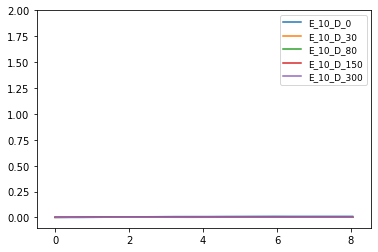

In [35]:
# group4_figure
# 1*5 labels, 4 repeats
LABEL = ['E_10_D_0', 'E_10_D_30', 'E_10_D_80', 'E_10_D_150', 'E_10_D_300']
# blue, green, red, cyan, magenta, yellow, black
# COLOR = ['black', 'blue', 'green', 'yellow', 'cyan']
for j in [0, 3, 4, 1, 2]:
    print("label: ", label_rawdata_np[j*4,:2])
    average_row = np.zeros((1,min_size-before_remove_data_size-3))
    for i in range(j*4, j*4+4):
        average_row = np.add(average_row, label_rawdata_np[i,3:])
    average_row = np.divide(average_row, 4)
    # print(average_row.shape)
    x = np.arange(0, float(average_row.shape[1]/200), 1/200)
    plt.plot(x,(-1)*average_row[0])

axes = plt.gca()
axes.set_xlim([-0.5,float(average_row.shape[1]/200)+0.5])
axes.set_ylim([-0.1,2])
plt.legend(LABEL, loc='best', fontsize=9)
plt.show()

In [16]:
def handling_data(detect_dir, y0, after_remove_data_size=0):
    # detect_dir = "./Data-Group4/Data-Group4-250LM/"
    all_rawdata, all_laebl = load_rawdata_with_labels(detect_dir)

    print("Rawdata shape: ", all_rawdata.shape)
    print("Rawdata labels shape: ", all_laebl.shape)


    lev = 5
    window_len = 200

    channels_n = all_rawdata.shape[1]
    rawdata_wavelet_np = all_rawdata.copy()
    rawdata_smooth_np = all_rawdata.copy()


    for i in range(channels_n):
        wavelet_test_np = all_rawdata[:, i].reshape(-1,)
        rawdata_wavelet_np[:, i] = wden(wavelet_test_np, 'heursure', 'soft', 'one', lev, 'sym8')
        rawdata_smooth_np[:, i] = smooth(rawdata_wavelet_np[:-(window_len-1), i], window_len)

    # print(rawdata_smooth_np.shape)
    # 给all_laebl最后多加上一行用于区分
    if rawdata_smooth_np.shape[0] == all_laebl.shape[0]:
        all_laebl = np.r_[all_laebl, [[1000, 1000, 1000]]]
    # print(all_laebl.shape)

    # [H, V, O, n rows data]
    label_rawdata_np = []
    temp_label = all_laebl[0,:]
    cnt = 0
    for i in range(all_laebl.shape[0]):
        if (all_laebl[i,:] == temp_label).all():
            continue
        else:
            # 改变格式
            # print(temp_label)
            dd = np.r_[temp_label, rawdata_smooth_np[cnt:i,0].copy()]
            label_rawdata_np.append(dd)
            cnt = i
            temp_label = all_laebl[i,:]

    label_rawdata_np = np.array(label_rawdata_np)
    # print(label_rawdata_np.shape)
    group_size = label_rawdata_np.shape[0]

    test_max_i = 0
    test_min_i = 12000
    for j in range(group_size):
        for i in range(200*3, label_rawdata_np[j].shape[0]):
            if label_rawdata_np[j][i] < y0:
                baseline = label_rawdata_np[j][i]
                # 打印第一个满足的值
                # print(baseline)

                # 打印del之前的数组长度
                # print(label_rawdata_np[j].shape[0])

                # 打印截掉位置对应的i
                # print(i)

                # i之后的数据统一减去baseline
                for k in range(i, label_rawdata_np[j].shape[0]):
                    label_rawdata_np[j][k] = label_rawdata_np[j][k] - baseline

                # 将3:i数据移除
                for k in range(3, i):
                    label_rawdata_np[j] = np.delete(label_rawdata_np[j], 3)

                # 打印del之后的数组长度
                # print(label_rawdata_np[j].shape[0])
                test_max_i = i if i > test_max_i else test_max_i
                test_min_i = i if i < test_min_i else test_min_i

                break;

    print("test_max_and_min_i: ", test_max_i, test_min_i)  # 打印数据中最小和最大的i

    min_size = 10000000000
    for i in range(group_size):
        size = label_rawdata_np[i].shape[0]
        min_size = size if size < min_size else min_size

    print("min_size: ", min_size)

    min_size = min_size - after_remove_data_size
    # 统一所有数据长度
    for i in range(group_size):
        # 将 min_size 之后的数据移除
        for k in range(min_size, label_rawdata_np[i].shape[0]):
            label_rawdata_np[i] = np.delete(label_rawdata_np[i], min_size)
        # 打印删除后的长度
        # print(label_rawdata_np[i].shape[0])

    # list转np
    label_rawdata_np_temp = np.empty((0,min_size))
    for i in range(group_size):
        label_rawdata_np_temp = np.r_[label_rawdata_np_temp, [label_rawdata_np[i]]]

    label_rawdata_np = label_rawdata_np_temp
    print("label_rawdata_np.shape: ", label_rawdata_np.shape)
    # plt.plot(label_rawdata_np[0,3:])
    # plt.show()
    return label_rawdata_np, min_size

Loading OPV data ..........
Rawdata shape:  (57799, 2)
Rawdata labels shape:  (57799, 3)


<ipython-input-16-7b5f6d1d5784>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_rawdata_np = np.array(label_rawdata_np)


test_max_and_min_i:  1394 1014
min_size:  1377
label_rawdata_np.shape:  (20, 1377)
label:  [250.   0.]
label:  [250.  30.]
label:  [250.  80.]
label:  [250. 150.]
label:  [250. 300.]


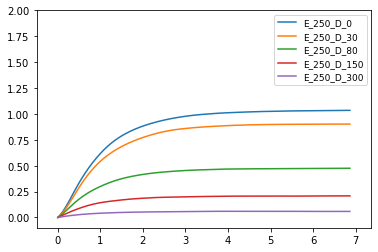

In [17]:
# group4_figure
# 1*5 labels, 4 repeats
label_rawdata_np, min_size = handling_data('./Data-Group4/Data-Group4-250LM/', -0.05)
LABEL = ['E_250_D_0', 'E_250_D_150', 'E_250_D_300', 'E_250_D_30', 'E_250_D_80']
LABEL = ['E_250_D_0', 'E_250_D_30', 'E_250_D_80', 'E_250_D_150', 'E_250_D_300']
# blue, green, red, cyan, magenta, yellow, black
# COLOR = ['black', 'blue', 'green', 'yellow', 'cyan']
for j in [0, 3, 4, 1, 2]:
    print("label: ", label_rawdata_np[j*4,:2])
    average_row = np.zeros((1,min_size-3))
    for i in range(j*4, j*4+4):
        average_row = np.add(average_row, label_rawdata_np[i,3:])
    average_row = np.divide(average_row, 4)
    # print(average_row.shape)
    x = np.arange(0, float(average_row.shape[1]/200), 1/200)
    plt.plot(x,(-1)*average_row[0])

axes = plt.gca()
axes.set_xlim([-0.5,float(average_row.shape[1]/200)+0.5])
axes.set_ylim([-0.1,2])
plt.legend(LABEL, loc='best', fontsize=9)
plt.show()

Loading OPV data ..........
Rawdata shape:  (57672, 2)
Rawdata labels shape:  (57672, 3)


<ipython-input-7-21c1551d97af>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_rawdata_np = np.array(label_rawdata_np)


test_max_and_min_i:  1351 1065
min_size:  1523
label_rawdata_np.shape:  (20, 1523)
label:  [500.   0.]
label:  [500.  30.]
label:  [500.  80.]
label:  [500. 150.]
label:  [500. 300.]


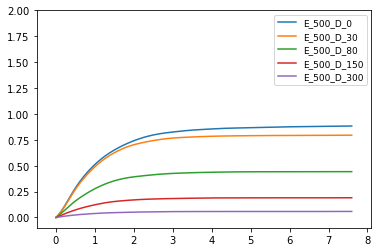

In [11]:
# group4_figure
# 1*5 labels, 4 repeats
label_rawdata_np, min_size = handling_data('./Data-Group4/Data-Group4-500LM/', -0.05)
LABEL = ['E_500_D_0', 'E_500_D_150', 'E_500_D_300', 'E_500_D_30', 'E_500_D_80']
LABEL = ['E_500_D_0', 'E_500_D_30', 'E_500_D_80', 'E_500_D_150', 'E_500_D_300']
# blue, green, red, cyan, magenta, yellow, black
# COLOR = ['black', 'blue', 'green', 'yellow', 'cyan']
for j in [0, 3, 4, 1, 2]:
    print("label: ", label_rawdata_np[j*4,:2])
    average_row = np.zeros((1,min_size-3))
    for i in range(j*4, j*4+4):
        average_row = np.add(average_row, label_rawdata_np[i,3:])
    average_row = np.divide(average_row, 4)
    # print(average_row.shape)
    x = np.arange(0, float(average_row.shape[1]/200), 1/200)
    plt.plot(x,(-1)*average_row[0])

axes = plt.gca()
axes.set_xlim([-0.5,float(average_row.shape[1]/200)+0.5])
axes.set_ylim([-0.1,2])
plt.legend(LABEL, loc='best', fontsize=9)
plt.show()

Loading OPV data ..........
Rawdata shape:  (87327, 2)
Rawdata labels shape:  (87327, 3)


<ipython-input-7-21c1551d97af>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_rawdata_np = np.array(label_rawdata_np)


test_max_and_min_i:  1278 1084
min_size:  1610
label_rawdata_np.shape:  (30, 1610)
label:  [1750.    0.]
label:  [1750.   30.]
label:  [1750.   80.]
label:  [1750.  150.]
label:  [1750.  300.]


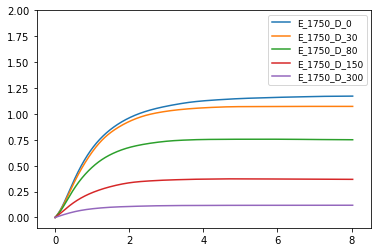

In [12]:
# group4_figure
# 1*5 labels, 6 repeats
label_rawdata_np, min_size = handling_data('./Data-Group4/Data-Group4-1750LM/', -0.05)
LABEL = ['E_1750_D_0', 'E_1750_D_30', 'E_1750_D_80', 'E_1750_D_150', 'E_1750_D_300']
# blue, green, red, cyan, magenta, yellow, black
# COLOR = ['black', 'blue', 'green', 'yellow', 'cyan']
for j in [0, 3, 4, 1, 2]:
    print("label: ", label_rawdata_np[j*6,:2])
    average_row = np.zeros((1,min_size-3))
    for i in range(j*6, j*6+6):
        average_row = np.add(average_row, label_rawdata_np[i,3:])
    average_row = np.divide(average_row, 6)
    # print(average_row.shape)
    x = np.arange(0, float(average_row.shape[1]/200), 1/200)
    plt.plot(x,(-1)*average_row[0])

axes = plt.gca()
axes.set_xlim([-0.5,float(average_row.shape[1]/200)+0.5])
axes.set_ylim([-0.1,2])
plt.legend(LABEL, loc='best', fontsize=9)
plt.show()

Loading OPV data ..........
Rawdata shape:  (85440, 2)
Rawdata labels shape:  (85440, 3)


<ipython-input-7-21c1551d97af>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_rawdata_np = np.array(label_rawdata_np)


test_max_and_min_i:  1240 1048
min_size:  1549
label_rawdata_np.shape:  (30, 1549)
label:  [3500.    0.]
label:  [3500.   30.]
label:  [3500.   80.]
label:  [3500.  150.]
label:  [3500.  300.]


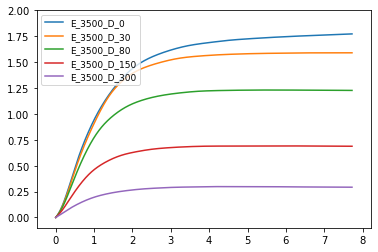

In [13]:
# group4_figure
# 1*5 labels, 6 repeats
label_rawdata_np, min_size = handling_data('./Data-Group4/Data-Group4-3500LM/', -0.05)
LABEL = ['E_3500_D_0', 'E_3500_D_30', 'E_3500_D_80', 'E_3500_D_150', 'E_3500_D_300']
# blue, green, red, cyan, magenta, yellow, black
# COLOR = ['black', 'blue', 'green', 'yellow', 'cyan']
for j in [0, 3, 4, 1, 2]:
    print("label: ", label_rawdata_np[j*6,:2])
    average_row = np.zeros((1,min_size-3))
    for i in range(j*6, j*6+6):
        average_row = np.add(average_row, label_rawdata_np[i,3:])
    average_row = np.divide(average_row, 6)
    # print(average_row.shape)
    x = np.arange(0, float(average_row.shape[1]/200), 1/200)
    plt.plot(x,(-1)*average_row[0])

axes = plt.gca()
axes.set_xlim([-0.5,float(average_row.shape[1]/200)+0.5])
axes.set_ylim([-0.1,2])
plt.legend(LABEL, loc='best', fontsize=9)
plt.show()

Loading OPV data ..........
Rawdata shape:  (57672, 2)
Rawdata labels shape:  (57672, 3)


<ipython-input-16-7b5f6d1d5784>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_rawdata_np = np.array(label_rawdata_np)


test_max_and_min_i:  1351 1065
min_size:  1523
label_rawdata_np.shape:  (20, 1523)
label:  [500.   0.]
Loading OPV data ..........
Rawdata shape:  (87327, 2)
Rawdata labels shape:  (87327, 3)


<ipython-input-16-7b5f6d1d5784>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_rawdata_np = np.array(label_rawdata_np)


test_max_and_min_i:  1278 1084
min_size:  1610
label_rawdata_np.shape:  (30, 1523)
label:  [1750.    0.]
Loading OPV data ..........
Rawdata shape:  (85440, 2)
Rawdata labels shape:  (85440, 3)


<ipython-input-16-7b5f6d1d5784>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_rawdata_np = np.array(label_rawdata_np)


test_max_and_min_i:  1240 1048
min_size:  1549
label_rawdata_np.shape:  (30, 1523)
label:  [3500.    0.]


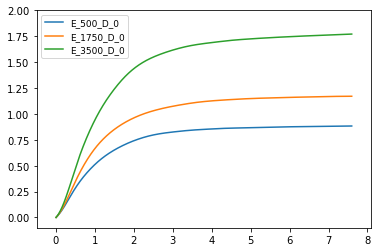

In [20]:
# label_rawdata_np_500, min_size_500 = handling_data('./Data-Group4/Data-Group4-500LM/', -0.05)
# label_rawdata_np_1750, min_size_1750 = handling_data('./Data-Group4/Data-Group4-1750LM/', -0.05)
# label_rawdata_np_3500, min_size_3500 = handling_data('./Data-Group4/Data-Group4-3500LM/', -0.05)
LABEL = ['E_500_D_0', 'E_1750_D_0', 'E_3500_D_0']

for filename in ['./Data-Group4/Data-Group4-500LM/']:
    
    label_rawdata_np_500, min_size_500 = handling_data(filename, -0.05)
    print("label: ", label_rawdata_np_500[0,:2])
    average_row = np.zeros((1,min_size_500-3))
    for i in range(0, 4):
        average_row = np.add(average_row, label_rawdata_np_500[i,3:])
    average_row = np.divide(average_row, 4)
    # print(average_row.shape)
    x = np.arange(0, float(average_row.shape[1]/200), 1/200)
    plt.plot(x,(-1)*average_row[0])

for filename in ['./Data-Group4/Data-Group4-1750LM/']:
    
    label_rawdata_np_500, min_size_500 = handling_data(filename, -0.05, 87)
    print("label: ", label_rawdata_np_500[0,:2])
    average_row = np.zeros((1,min_size_500-3))
    for i in range(0, 6):
        average_row = np.add(average_row, label_rawdata_np_500[i,3:])
    average_row = np.divide(average_row, 6)
    # print(average_row.shape)
    x = np.arange(0, float(average_row.shape[1]/200), 1/200)
    plt.plot(x,(-1)*average_row[0])

for filename in ['./Data-Group4/Data-Group4-3500LM/']:
    
    label_rawdata_np_500, min_size_500 = handling_data(filename, -0.05, 26)
    print("label: ", label_rawdata_np_500[0,:2])
    average_row = np.zeros((1,min_size_500-3))
    for i in range(0, 6):
        average_row = np.add(average_row, label_rawdata_np_500[i,3:])
    average_row = np.divide(average_row, 6)
    # print(average_row.shape)
    x = np.arange(0, float(average_row.shape[1]/200), 1/200)
    plt.plot(x,(-1)*average_row[0])




axes = plt.gca()
axes.set_xlim([-0.5,float(average_row.shape[1]/200)+0.5])
axes.set_ylim([-0.1,2])
plt.legend(LABEL, loc='best', fontsize=9)
plt.show()




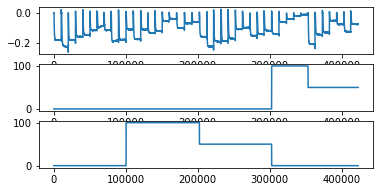

In [44]:
n = 200*3

# plt.subplot(411)
# plt.plot(all_rawdata[:, 0])
plt.subplot(412)
plt.plot(rawdata_wavelet_np[:, 0])
plt.subplot(413)
plt.plot(all_laebl[:, 0])
plt.subplot(414)
plt.plot(all_laebl[:, 1])


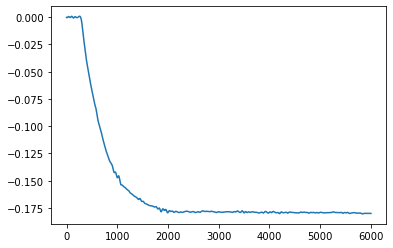

In [48]:
plt.plot(rawdata_wavelet_np[:400*15, 0])

In [ ]:
# data segmentation







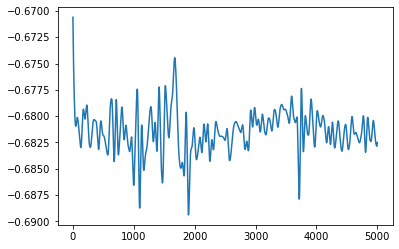

In [7]:
plt.plot(rawdata_wavelet_np[:200*25, 0])


In [13]:
def plot_LM_and_Dis(detect_dir):
    all_rawdata, all_laebl = load_rawdata_with_labels(detect_dir)
    print("Rawdata shape: ", all_rawdata.shape)
    print("Rawdata labels shape: ", all_laebl.shape)

    lev = 5

    channels_n = all_rawdata.shape[1]
    rawdata_wavelet_np = all_rawdata

    for i in range(channels_n):
        wavelet_test_np = all_rawdata[:, i].reshape(-1,)
        rawdata_wavelet_np[:, i] = wden(wavelet_test_np, 'heursure', 'soft', 'one', lev, 'sym8')

    plt.subplot(311)
    plt.plot(all_rawdata[:, 0])
    plt.subplot(312)
    plt.plot(rawdata_wavelet_np[:, 0])
    plt.subplot(313)
    plt.plot(all_laebl[:, 1])

../Data/Data-Group4-10LM/
Loading OPV data ..........
Rawdata shape:  (38158, 2)
Rawdata labels shape:  (38158, 3)


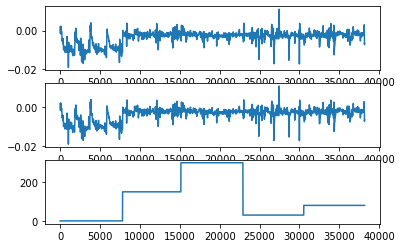

In [15]:
detect_dir = "../Data/Data-Group4-10LM/"
print(detect_dir)
plot_LM_and_Dis(detect_dir)


../Data/Data-Group4-250LM/
Loading OPV data ..........
Rawdata shape:  (37799, 2)
Rawdata labels shape:  (37799, 3)


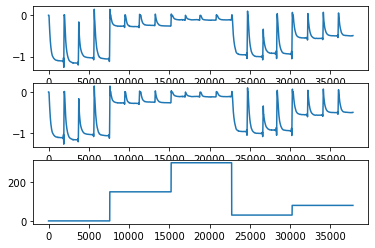

In [16]:

detect_dir = "../Data/Data-Group4-250LM/"
print(detect_dir)
plot_LM_and_Dis(detect_dir)



../Data/Data-Group4-500LM/
Loading OPV data ..........
Rawdata shape:  (37672, 2)
Rawdata labels shape:  (37672, 3)


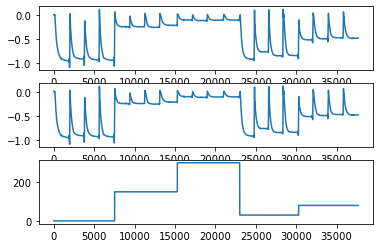

In [17]:
detect_dir = "../Data/Data-Group4-500LM/"
print(detect_dir)
plot_LM_and_Dis(detect_dir)



../Data/Data-Group4-1750LM/
Loading OPV data ..........
Rawdata shape:  (38463, 2)
Rawdata labels shape:  (38463, 3)


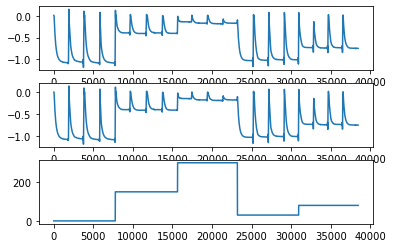

In [22]:
detect_dir = "../Data/Data-Group4-1750LM/"
print(detect_dir)
plot_LM_and_Dis(detect_dir)



../Data/Data-Group4-3500LM/
Loading OPV data ..........
Rawdata shape:  (37275, 2)
Rawdata labels shape:  (37275, 3)


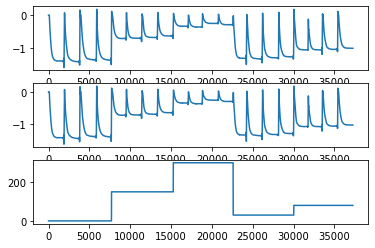

In [23]:
detect_dir = "../Data/Data-Group4-3500LM/"
print(detect_dir)
plot_LM_and_Dis(detect_dir)